In [50]:
import os
from pathlib import Path

import pandas as pd

from es_sfgtools.data_mgmt.data_handler import DataHandler

pride_path = Path.home() / ".PRIDE_PPPAR_BIN"
os.environ["PATH"] += os.pathsep + str(pride_path)
import matplotlib.pyplot as plt

%matplotlib ipympl

import sys

import numpy as np
import pymap3d

sys.path.append("/Users/franklyndunbar/Project/SeaFloorGeodesy/gnatss/src")
import datetime

import gnatss.constants as constants
from gnatss.ops.kalman import run_filter_simulation

In [51]:
GPS_EPOCH = datetime.datetime(1980, 1, 6, 0, 0, 0)
J200_EPOCH = datetime.datetime(2000, 1, 1, 12, 0, 0)


def time_to_gpsweek_seconds(time: datetime.datetime) -> tuple[int, float]:
    """
    Convert a datetime object to GPS week and seconds of week.
    """

    # Calculate the difference in time
    delta = time - GPS_EPOCH

    # Total seconds since GPS epoch
    total_seconds = delta.total_seconds()

    # Calculate GPS week and seconds of week
    gps_week = int(total_seconds // (7 * 24 * 3600))
    seconds_of_week = total_seconds % (7 * 24 * 3600)

    return gps_week, seconds_of_week


def time_to_j200(time: datetime.datetime) -> float:
    """
    Convert a datetime object to Julian Date (JD) and then to J2000.
    """
    # Calculate the difference in time
    delta = time - J200_EPOCH

    # Total seconds since J2000 epoch
    total_seconds = delta.total_seconds()

    return total_seconds

In [52]:
main_dir = Path("/Users/franklyndunbar/Project/SeaFloorGeodesy/Data/SFGMain")
dh = DataHandler(main_dir)

network = "cascadia-gorda"
station = "NCC1"
survey = "2023_A_1063"

dh.change_working_station(network=network, station=station, campaign=survey)

Built directory structure for cascadia-gorda NCC1 2023_A_1063
No date range set for cascadia-gorda, NCC1, 2023_A_1063
Creating TileDB arrays for NCC1
Consolidating existing TileDB arrays for NCC1
Changed working station to cascadia-gorda NCC1 2023_A_1063


In [53]:
print(dates:=dh.kin_position_tdb.get_unique_dates())

['2022-05-01' '2022-05-03' '2022-05-04' '2022-05-05' '2022-05-06'
 '2022-05-07' '2022-05-08' '2022-05-09' '2023-09-08' '2023-09-09'
 '2023-09-10' '2023-09-11' '2023-09-12' '2023-09-13' '2023-09-14']


In [54]:
kin_positions = dh.kin_position_tdb.read_df(dates[8], dates[9])
shotdata = dh.shotdata_tdb_pre.read_df(dates[8], dates[9])
positions_data = dh.imu_position_tdb.read_df(dates[8], dates[9])
positions_data.time = positions_data.time.apply(lambda x: x.timestamp())
kin_positions.time = kin_positions.time.apply(lambda x: x.timestamp())

In [55]:
print(f"Kin shape: {kin_positions.shape[0]}")
print(f"Pos shape: {positions_data.shape[0]}")
time_cutoff = kin_positions.iloc[kin_positions.shape[0]//2]["time"]
cutoff_kin = np.searchsorted(kin_positions.time.to_numpy(),time_cutoff)
cutoff_pos = np.searchsorted(positions_data.time.to_numpy(),time_cutoff)
kin_positions = kin_positions.iloc[cutoff_kin:]
positions_data = positions_data.iloc[cutoff_pos:]
print(f"Kin shape: {kin_positions.shape[0]}")
print(f"Pos shape: {positions_data.shape[0]}")

Kin shape: 430336
Pos shape: 2386403
Kin shape: 215168
Pos shape: 1930174


In [56]:
e,n,u = pymap3d.geodetic2ecef(lat=positions_data.latitude,lon=positions_data.longitude,alt=positions_data.height)
positions_data["ant_x"],positions_data["ant_y"],positions_data["ant_z"] = e,n,u
positions_data["east"] = positions_data.eastVelocity
positions_data["north"] = positions_data.northVelocity
positions_data["up"] = positions_data.upVelocity
positions_data.head()

,time,azimuth,pitch,roll,latitude,longitude,height,latitude_std,longitude_std,height_std,...,upVelocity_std,roll_std,pitch_std,azimuth_std,ant_x,ant_y,ant_z,east,north,up
456229,1.694205e+09,294.430621,-3.370229,-8.353673,41.672817,-124.934957,-31.8771,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.732218e+06,-3.911454e+06,4.218507e+06,-1.4288,0.5402,-1.0756
456230,1.694205e+09,294.981495,-2.469668,-9.492273,41.672817,-124.934958,-31.9323,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.732218e+06,-3.911454e+06,4.218507e+06,-1.4269,0.6365,-0.9364
456231,1.694205e+09,295.518648,-1.504356,-10.161759,41.672817,-124.934958,-31.9801,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.732218e+06,-3.911454e+06,4.218507e+06,-1.4194,0.7178,-0.7858
456232,1.694205e+09,296.043097,-0.515300,-10.371391,41.672818,-124.934959,-32.0197,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.732218e+06,-3.911454e+06,4.218507e+06,-1.4068,0.8086,-0.5977
456233,1.694205e+09,296.570583,0.471418,-10.221569,41.672818,-124.934960,-32.0495,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.732218e+06,-3.911454e+06,4.218507e+06,-1.3961,0.8698,-0.4248


In [57]:
kin_positions.head()

,time,latitude,longitude,height,east,north,up,number_of_satellites,pdop,wrms
215168,1.694205e+09,41.672814,235.065041,-29.8675,-2.732219e+06,-3.911455e+06,4.218508e+06,8,2.14,NaN
215169,1.694205e+09,41.672815,235.065040,-29.9595,-2.732219e+06,-3.911455e+06,4.218508e+06,8,2.14,NaN
215170,1.694205e+09,41.672815,235.065038,-30.0241,-2.732219e+06,-3.911455e+06,4.218508e+06,8,2.14,NaN
215171,1.694205e+09,41.672816,235.065037,-30.0524,-2.732219e+06,-3.911455e+06,4.218508e+06,8,2.14,NaN
215172,1.694205e+09,41.672817,235.065035,-30.0540,-2.732219e+06,-3.911455e+06,4.218509e+06,8,2.14,NaN


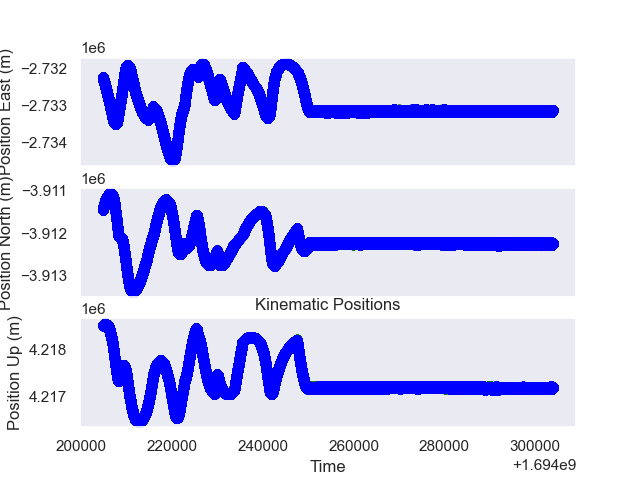

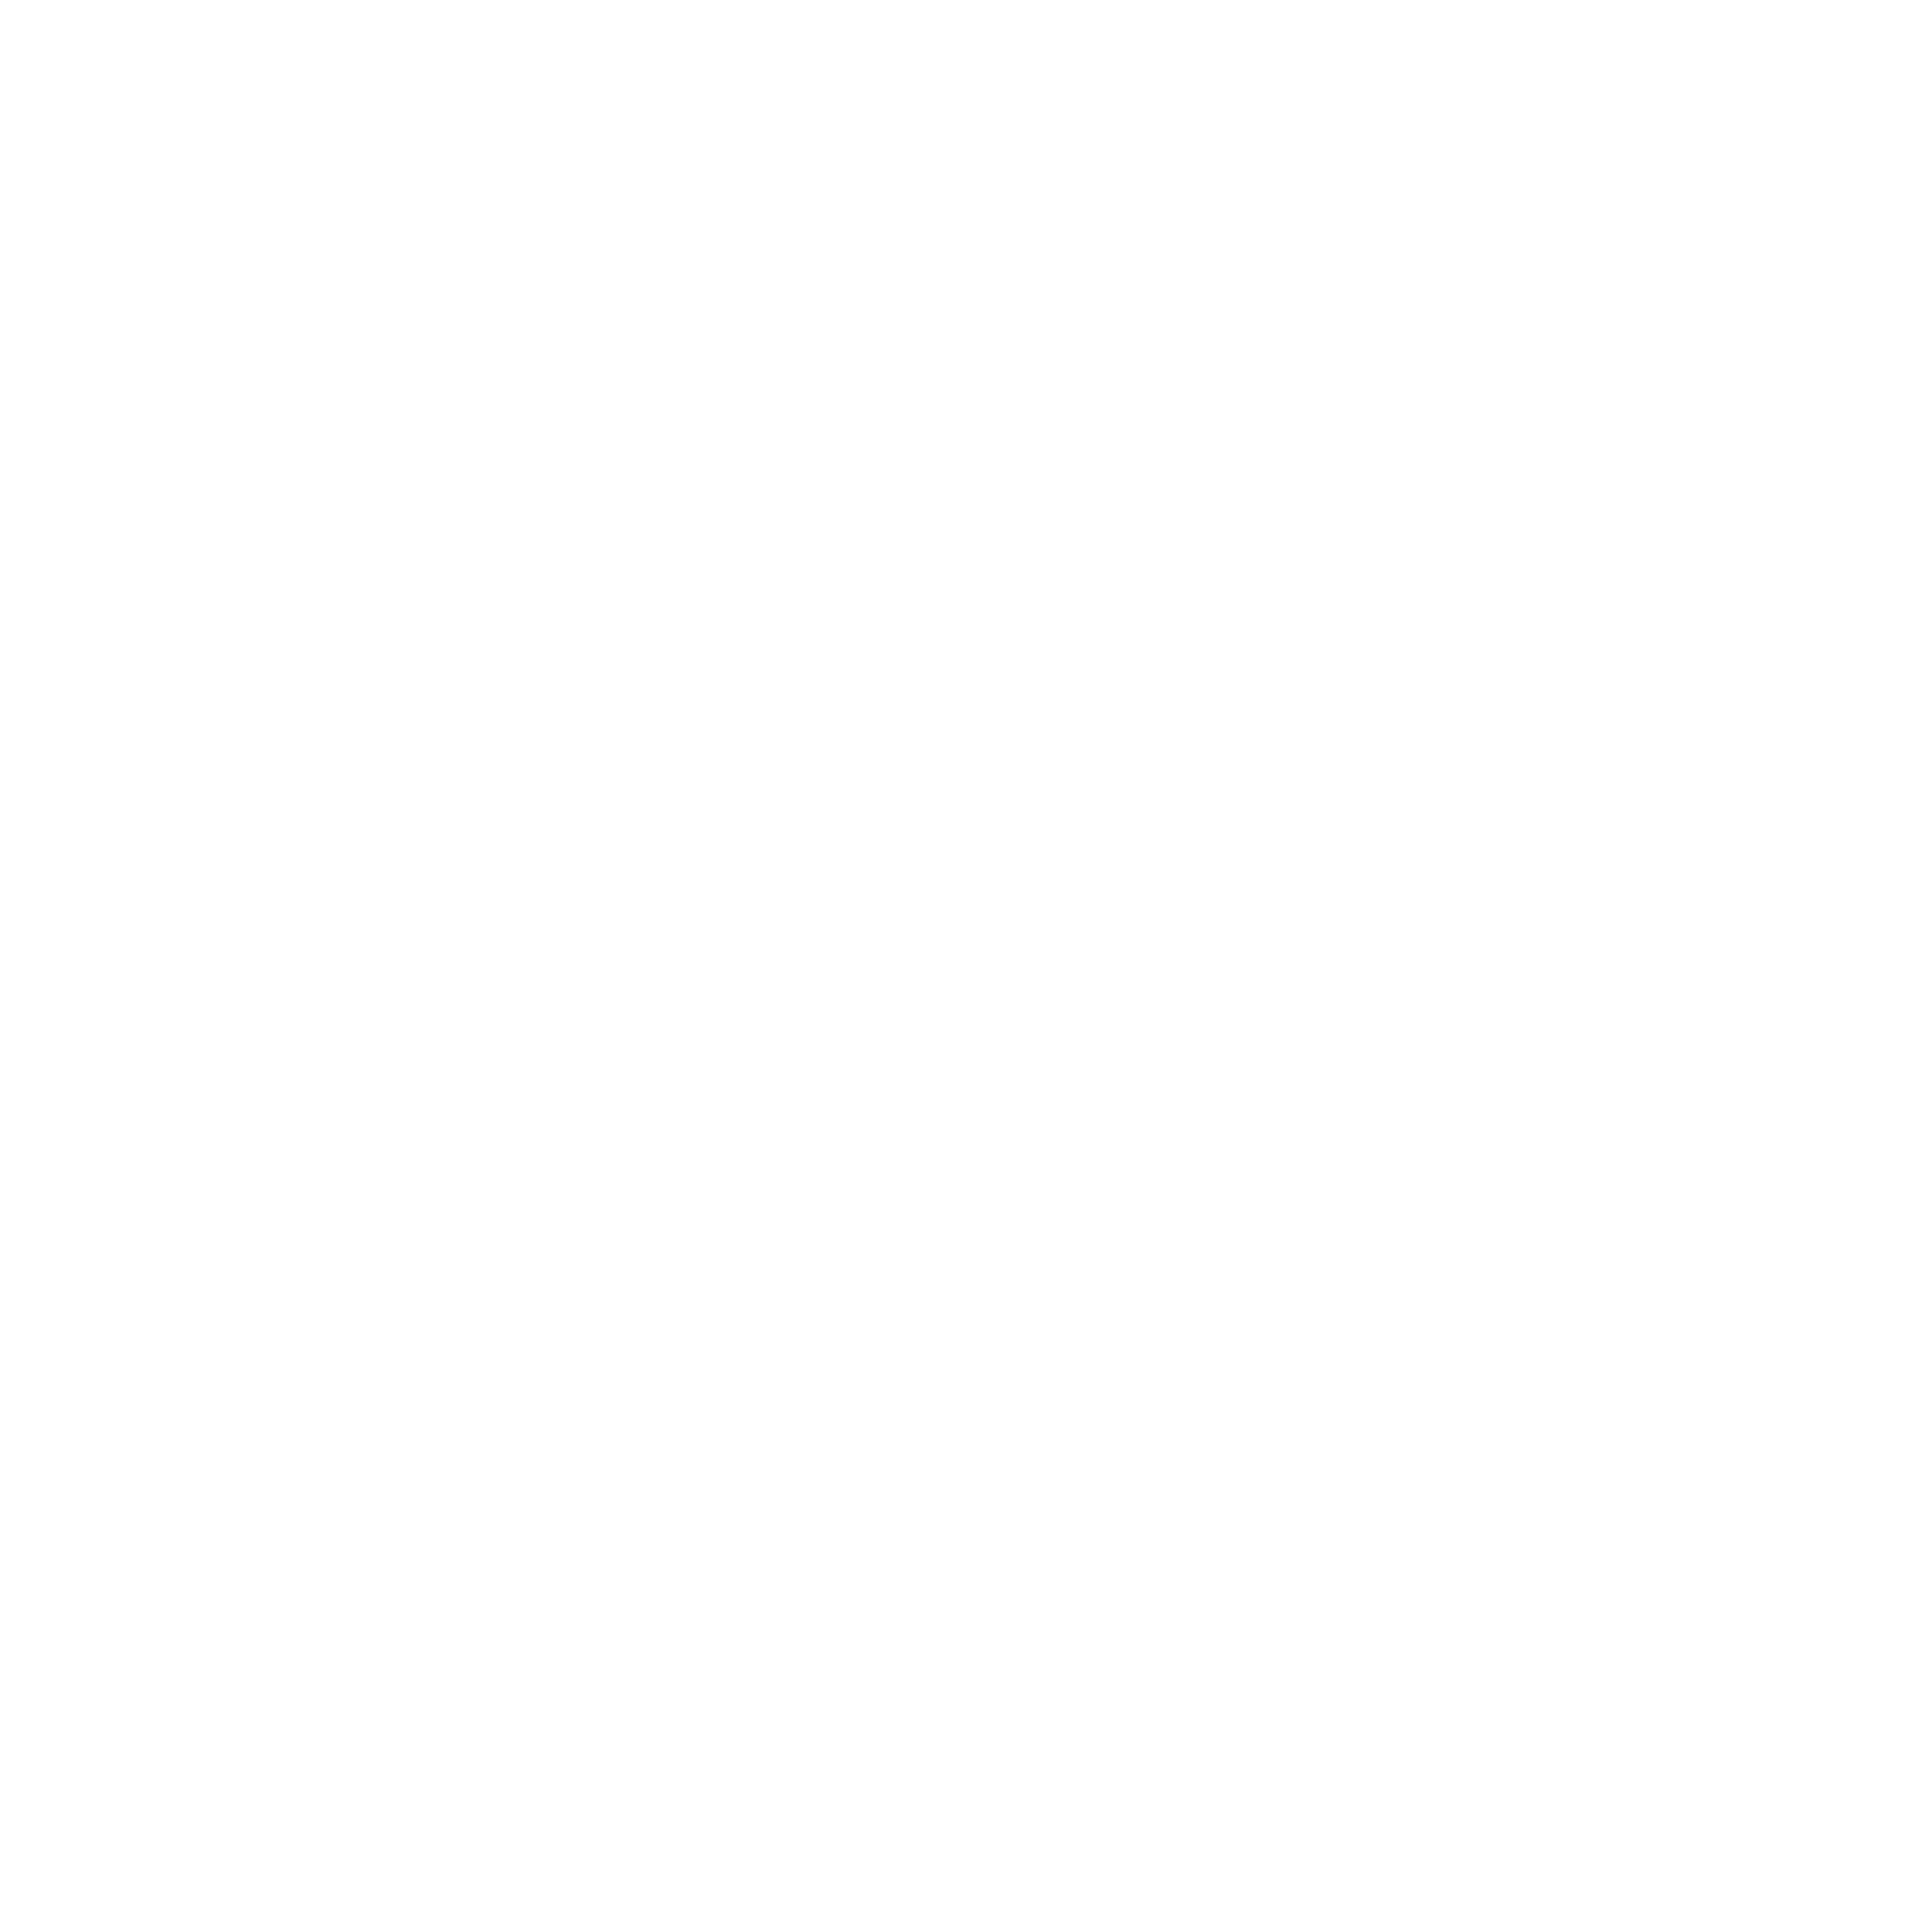

In [58]:
plt.ion()  # Turn on interactive mode
plt.figure(figsize=(16*2, 16*2))
fig,axes = plt.subplots(3,1,sharex=True)

axes[0].scatter(kin_positions['time'], kin_positions["east"], label='East',color='green')
axes[0].scatter(positions_data["time"],positions_data["ant_x"],label='East',color='blue')

axes[0].set_ylabel('Position East (m)')
# axes[0].legend()
axes[0].grid()

axes[1].scatter(
    kin_positions["time"], kin_positions["north"], label="North", color="green"
)
axes[1].scatter(
    positions_data["time"],
    positions_data["ant_y"],
    label="North",
    color="blue",

)

axes[1].set_ylabel('Position North (m)')
# axes[1].legend()
axes[1].grid()

axes[2].scatter(
    kin_positions["time"], kin_positions["up"], label="Up", color="green"
)
axes[2].scatter(
    positions_data["time"],
    positions_data["ant_z"],
    label="Up",
    color="blue",

)


axes[2].set_xlabel('Time')
axes[2].set_ylabel('Position Up (m)')
# axes[2].legend()
axes[2].grid()

plt.title('Kinematic Positions')
plt.show()

In [59]:
gps_df = kin_positions.copy()
east_velocity = (gps_df.east.diff() / gps_df.time.diff()).abs()
north_velocity = (gps_df.north.diff() / gps_df.time.diff()).abs()
up_velocity = (gps_df.up.diff() / gps_df.time.diff()).abs()

gps_df["ant_x"] = gps_df["east"]
gps_df["ant_y"] = gps_df["north"]
gps_df["ant_z"] = gps_df["up"]

gps_df["east"] = east_velocity
gps_df["north"] = north_velocity
gps_df["up"] = up_velocity

gps_df["ant_sigx"] = .1
gps_df["ant_sigy"] = .1
gps_df["ant_sigz"] = .1

gps_df["rho_xy"] = 0
gps_df["rho_xz"] = 0
gps_df["rho_yz"] = 0

gps_df["east_sig"] = 2
gps_df["north_sig"] = 2
gps_df["up_sig"] = 2

gps_df["v_sden"] = 2
gps_df["v_sdeu"] = 2
gps_df["v_sdnu"] = 2
gps_df["source"] = 'KINEMATIC'
gps_df = gps_df.iloc[2:]

In [60]:
gps_df.east.describe()

count    215166.000000
mean          0.435530
std           0.324363
min           0.000000
25%           0.175400
50%           0.371214
75%           0.630760
max           6.226026
Name: east, dtype: float64

In [61]:
gps_df.head()

,time,latitude,longitude,height,east,north,up,number_of_satellites,pdop,wrms,...,rho_xy,rho_xz,rho_yz,east_sig,north_sig,up_sig,v_sden,v_sdeu,v_sdnu,source
215170,1.694205e+09,41.672815,235.065038,-30.0241,0.454455,1.572276,0.195049,8,2.14,NaN,...,0,0,0,2,2,2,2,2,2,KINEMATIC
215171,1.694205e+09,41.672816,235.065037,-30.0524,0.564647,1.346465,0.446465,8,2.14,NaN,...,0,0,0,2,2,2,2,2,2,KINEMATIC
215172,1.694205e+09,41.672817,235.065035,-30.0540,0.591089,1.295049,0.788118,8,2.14,NaN,...,0,0,0,2,2,2,2,2,2,KINEMATIC
215173,1.694205e+09,41.672818,235.065034,-30.0189,0.803030,1.076768,1.008081,8,2.14,NaN,...,0,0,0,2,2,2,2,2,2,KINEMATIC
215174,1.694205e+09,41.672819,235.065032,-29.9451,0.835643,0.879207,1.371286,8,2.14,NaN,...,0,0,0,2,2,2,2,2,2,KINEMATIC


In [62]:
positions_data.head()

,time,azimuth,pitch,roll,latitude,longitude,height,latitude_std,longitude_std,height_std,...,upVelocity_std,roll_std,pitch_std,azimuth_std,ant_x,ant_y,ant_z,east,north,up
456229,1.694205e+09,294.430621,-3.370229,-8.353673,41.672817,-124.934957,-31.8771,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.732218e+06,-3.911454e+06,4.218507e+06,-1.4288,0.5402,-1.0756
456230,1.694205e+09,294.981495,-2.469668,-9.492273,41.672817,-124.934958,-31.9323,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.732218e+06,-3.911454e+06,4.218507e+06,-1.4269,0.6365,-0.9364
456231,1.694205e+09,295.518648,-1.504356,-10.161759,41.672817,-124.934958,-31.9801,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.732218e+06,-3.911454e+06,4.218507e+06,-1.4194,0.7178,-0.7858
456232,1.694205e+09,296.043097,-0.515300,-10.371391,41.672818,-124.934959,-32.0197,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.732218e+06,-3.911454e+06,4.218507e+06,-1.4068,0.8086,-0.5977
456233,1.694205e+09,296.570583,0.471418,-10.221569,41.672818,-124.934960,-32.0495,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-2.732218e+06,-3.911454e+06,4.218507e+06,-1.3961,0.8698,-0.4248


In [63]:
positions_data_copy = positions_data.copy()

positions_data_copy["ant_sigx"] = positions_data_copy["latitude_std"]
positions_data_copy["ant_sigy"] = positions_data_copy["longitude_std"]
positions_data_copy["ant_sigz"] = positions_data_copy["height_std"]
positions_data_copy["rho_xy"] = 0
positions_data_copy["rho_xz"] = 0
positions_data_copy["rho_yz"] = 0

positions_data_copy["east_sig"] = positions_data_copy["eastVelocity_std"]
positions_data_copy["north_sig"] = positions_data_copy["northVelocity_std"]
positions_data_copy["up_sig"] = positions_data_copy["upVelocity_std"]

positions_data_copy["v_sden"] = 1
positions_data_copy["v_sdeu"] = 1
positions_data_copy["v_sdnu"] = 1


In [64]:
positions_data_copy.east.describe()

count    1.930174e+06
mean    -4.025252e-03
std      5.577844e-01
min     -2.083800e+00
25%     -3.852000e-01
50%     -6.630000e-02
75%      3.270000e-01
max      2.699300e+00
Name: east, dtype: float64

In [65]:
df_all = pd.concat([positions_data_copy,gps_df])
column_order = ['time', 'east', 'north', 'up','ant_x', 'ant_y', 'ant_z','ant_sigx', 'ant_sigy', 'ant_sigz','rho_xy', 'rho_xz', 'rho_yz','east_sig', 'north_sig', 'up_sig','v_sden', 'v_sdeu', 'v_sdnu']
df_all = df_all[column_order]
df_all = df_all.sort_values(by="time")
df_all = df_all.dropna()
print(df_all.shape)


(216083, 19)


In [66]:
df_all.east.abs().describe()

count    216083.000000
mean          0.434941
std           0.324319
min           0.000000
25%           0.175000
50%           0.370297
75%           0.630015
max           6.226026
Name: east, dtype: float64

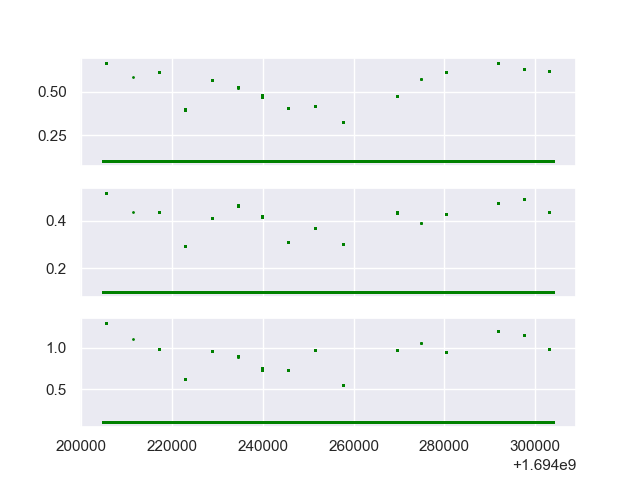

In [67]:
# plot covariance before filtering
fig,axes = plt.subplots(3,1,sharex=True)

axes[0].scatter(df_all['time'], df_all["ant_sigx"], label='East Sig',color='green',s=1)

axes[1].scatter(df_all['time'], df_all["ant_sigy"], label='North Sig',color='green',s=1)

axes[2].scatter(df_all['time'], df_all["ant_sigz"], label='Up Sig',color='green',s=1)



In [68]:
x, P, _, _ = run_filter_simulation(
    df_all.to_numpy(),
    constants.start_dt,
    constants.gnss_pos_psd,
    constants.vel_psd,
    constants.cov_err,
)

In [69]:
print(f"Start DT: {constants.start_dt}, GNSS_POS_PSD: {constants.gnss_pos_psd}, VEL_PSD: {constants.vel_psd}, COV_ERR: {constants.cov_err}")

Start DT: 0.05, GNSS_POS_PSD: 3.125e-05, VEL_PSD: 0.0025, COV_ERR: 0.25


In [70]:
# Positions covariance
ant_cov = P[:, :3, :3]
ant_cov_df = pd.DataFrame(ant_cov.reshape(ant_cov.shape[0], -1), columns=constants.ANT_GPS_COV)
ant_cov_df[[*constants.ANT_GPS_GEOCENTRIC_STD]] = ant_cov_df[
    [*constants.ANT_GPS_COV_DIAG]
].apply(np.sqrt)

# ant_cov_df[constants.GPS_TIME] = df_all["time"]

# Smoothed positions
smoothed_results = pd.DataFrame(
    x.reshape(x.shape[0], -1)[:, :3],
    columns=constants.ANT_GPS_GEOCENTRIC,
)
# Add a unique index for merging
smoothed_results["merge_idx"] = smoothed_results.index
ant_cov_df["merge_idx"] = ant_cov_df.index

smoothed_results[constants.GPS_TIME] = df_all[constants.GPS_TIME].reset_index(drop=True)
ant_cov_df[constants.GPS_TIME] = df_all[constants.GPS_TIME].reset_index(drop=True)

smoothed_results = smoothed_results.merge(ant_cov_df, on="merge_idx", how="left", suffixes=('', '_cov'))


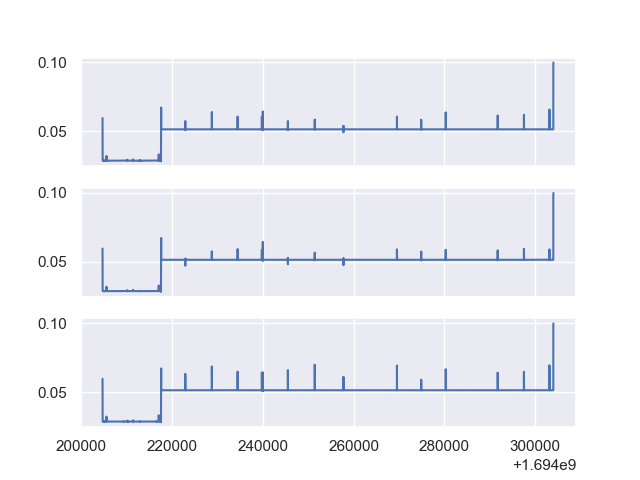

In [71]:
# plot antenna covariance in x,y,z
fig,axes = plt.subplots(3,1,sharex=True)
axes[0].plot(smoothed_results[constants.GPS_TIME], smoothed_results["ant_sigx"], label="X")
axes[1].plot(smoothed_results[constants.GPS_TIME], smoothed_results["ant_sigy"], label="Y")
axes[2].plot(smoothed_results[constants.GPS_TIME], smoothed_results["ant_sigz"], label="Z")

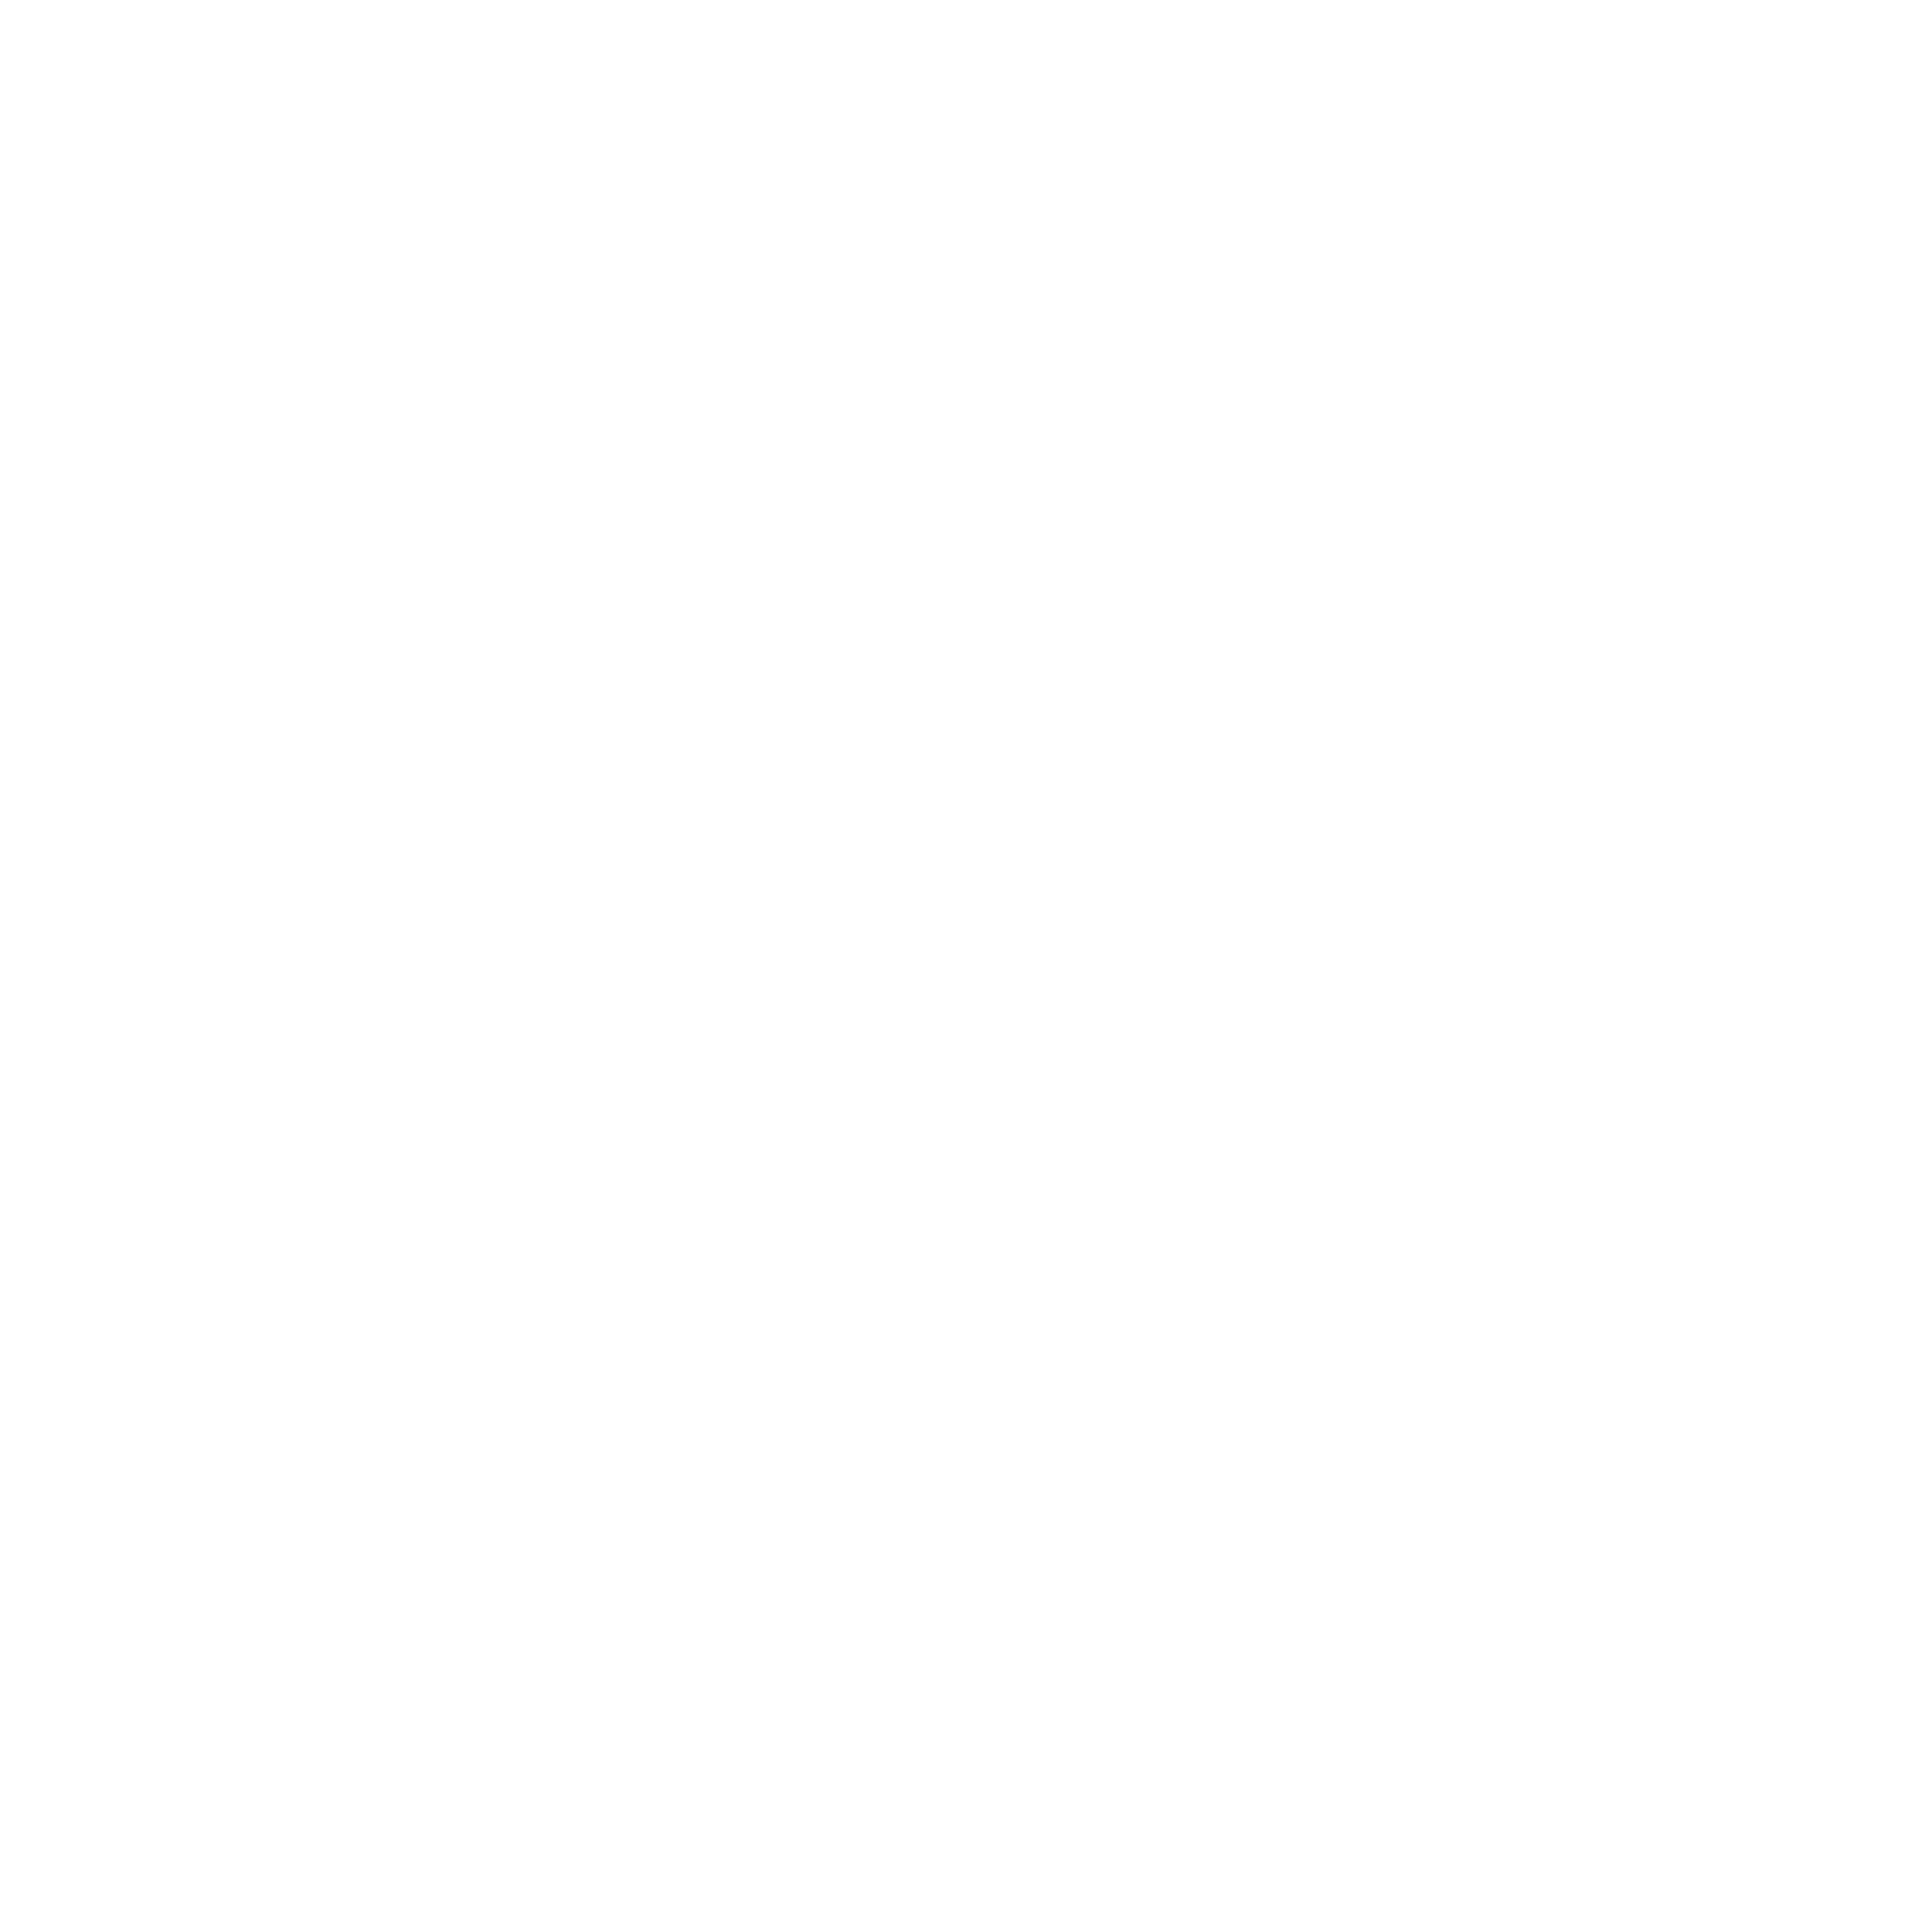

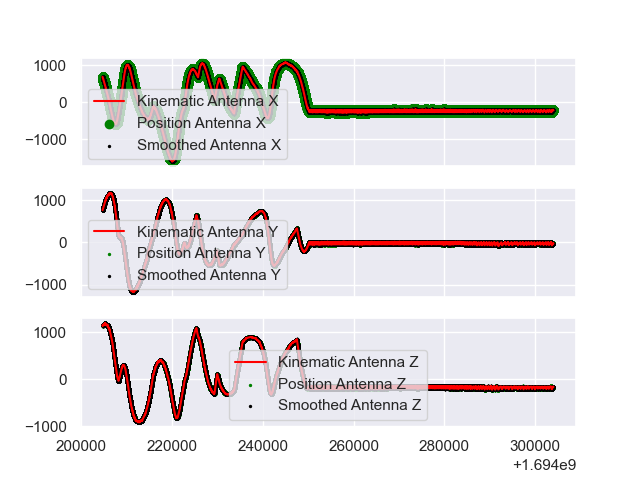

In [72]:
# compare position and results data
plt.ion()  # Turn on interactive mode
plt.figure(figsize=(16 * 2, 16 * 2))
fig, axes = plt.subplots(3, 1, sharex=True)


gps_mean_x = gps_df["ant_x"].mean()

gps_mean_y = gps_df["ant_y"].mean()

gps_mean_z = gps_df["ant_z"].mean()


axes[0].plot(
    gps_df["time"],
    gps_df["ant_x"]-gps_mean_x,
    label="Kinematic Antenna X",
    color="red"
)
axes[0].scatter(
    positions_data_copy["time"],
    positions_data_copy["ant_x"]-gps_mean_x,
    label="Position Antenna X",
    color="green",
)
axes[0].scatter(smoothed_results['time'], smoothed_results["ant_x"]-gps_mean_x, label='Smoothed Antenna X', color='black',s=2)
axes[0].legend()

axes[1].plot(
    gps_df["time"],
    gps_df["ant_y"]-gps_mean_y,
    label="Kinematic Antenna Y",
    color="red"
)
axes[1].scatter(
    positions_data_copy["time"],
    positions_data_copy["ant_y"]-gps_mean_y,
    label="Position Antenna Y",
    color="green",s=2
)
axes[1].scatter(smoothed_results['time'], smoothed_results["ant_y"]-gps_mean_y, label='Smoothed Antenna Y', color='black',s=2)

axes[1].legend()

axes[2].plot(
    gps_df["time"], gps_df["ant_z"]-gps_mean_z, label="Kinematic Antenna Z", color="red"
)
axes[2].scatter(
    positions_data_copy["time"],
    positions_data_copy["ant_z"]-gps_mean_z,
    label="Position Antenna Z",
    color="green",s=2
)
axes[2].scatter(smoothed_results['time'], smoothed_results["ant_z"]-gps_mean_z, label='Smoothed Antenna Z', color='black',s=2)

axes[2].legend()

In [74]:
# Check updated offsets
# Merge smoothed results back to positions data on time
merged_positions = pd.merge_asof(
    positions_data_copy.sort_values("time"),
    smoothed_results.sort_values("time"),
    on="time",
    direction="nearest",
    suffixes=('', '_smoothed')
)

In [82]:
print((merged_positions["ant_x_smoothed"] - merged_positions["ant_x"]).abs().describe())
# north_offset = (merged_positions["ant_y_smoothed"] - merged_positions["ant_y"]).mean()
# up_offset = (merged_positions["ant_z_smoothed"] - merged_positions["ant_z"]).mean()

count    1.930174e+06
mean     7.575719e-01
std      6.361168e-01
min      2.444722e-07
25%      2.897466e-01
50%      5.905989e-01
75%      1.072629e+00
max      9.079699e+00
dtype: float64


In [78]:
east_offset

-0.26942464046932835

In [79]:
north_offset

0.40996049409031465

In [80]:
up_offset

-0.07822215748186574